In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.base                import ForecastingHorizon

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender


from sktime.forecasting.compose import AutoEnsembleForecaster

import warnings

In [4]:
pdf = pd.read_csv("../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-12
y_train, y_test = pdf.iloc[:split], pdf.iloc[split:]

idx = pd.period_range(start=y_train.index[0], end= y_train.index[-1], freq="M")
y_train = pd.Series(y_train.y.values, index=idx)

In [5]:
warnings.filterwarnings('ignore')
arima = TransformedTargetForecaster([
                                    ("detrend",         Detrender(forecaster=TrendForecaster(Lasso()))),
                                    ("deseasonalize",   Deseasonalizer(model="additive", sp=12)),
                                    ("forecast",        ARIMA())  
                                    ])

prophet =   Prophet(seasonality_mode='additive',yearly_seasonality=True)
exp     =   ExponentialSmoothing(trend='add', seasonal='additive', sp=12)  
theta   =   ThetaForecaster(sp=12)

forecasters= {"theta":theta,
              "prophet":prophet,
              "arima with lasso-detrend": arima,
              "exp": exp,
              }

                
one_year_predictions = {}
five_years_predictions = {}

for name,forecaster in forecasters.items():
    forecaster.fit(y_train)
    #one year ahead prediction   
    idx = pd.period_range(start=y_test.index[0], end= y_test.index[-1], freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    one_year  = forecaster.predict(fh=horizon)
    one_year_predictions[name] = one_year

    #five years ahead prediction
    idx = pd.period_range(start=y_test.index[0], periods=60, freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    five_years  = forecaster.predict(fh=horizon)
    five_years_predictions[name] = five_years


13:37:30 - cmdstanpy - INFO - Chain [1] start processing
13:37:31 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# ensemble = StackingForecaster(forecasters=[("prophet",prophet),("exp",exp)])

# #five years ahead prediction
# idx = pd.period_range(start=y_test.index[0], periods=60, freq="M")
# horizon = ForecastingHorizon(idx, is_relative=False)
# ensemble.fit(y_test, fh= horizon)


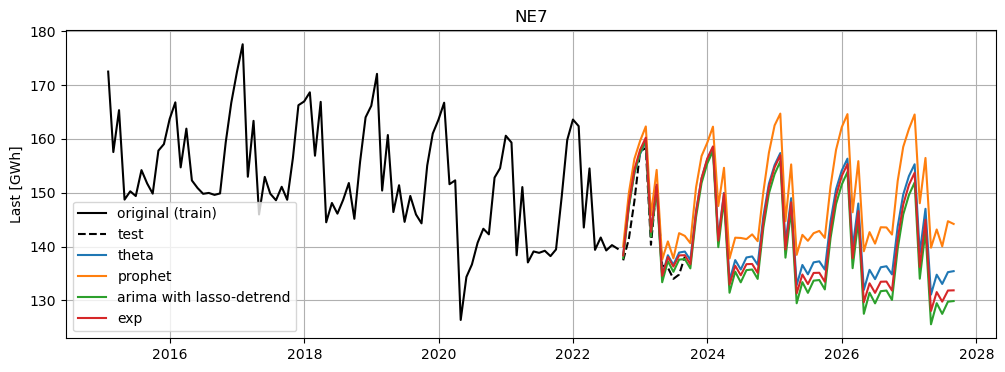

In [7]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(y_train.index.to_timestamp(freq="M"), y_train.values, color="black", label="original (train)")
axes.plot(y_test.index, y_test.values, color="black",linestyle="--",label="test")

for key, value in five_years_predictions.items():
    axes.plot(value.index.to_timestamp(freq="M"), value.values, label=key)

#axes.plot(ensemble.predict(fh=horizon).index, ensemble.predict(fh=horizon).values, label="ensemble")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [8]:
y_train

2015-01    172.482558
2015-02    157.543740
2015-03    165.323134
2015-04    148.718442
2015-05    150.259261
              ...    
2022-04    139.388619
2022-05    141.681254
2022-06    139.280821
2022-07    140.266726
2022-08    139.593984
Freq: M, Length: 92, dtype: float64

In [ ]:
#How to stich things together?

# fh = ForecastingHorizon(X_test.index, is_relative=False)
pipe = ForecastingPipeline(
    steps=[
        ("event_dynamics", WindowSummarizer(n_jobs=-1, **kwargs, target_cols=["event_type_1","event_type_2"])),
        ("snap_dynamics", WindowSummarizer(n_jobs=-1, target_cols=["snap"])),
        ("daily_season", DateTimeFeatures(ts_freq="D")),
        ("forecaster", forecaster),
    ]
)




# What is X_train exactly?
#display(X_train)
pipe_return = pipe.fit(y_train, X_train)
y_pred1 = pipe_return.predict(fh=1, X=X_test)
display(y_pred1)